In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import ruamel.yaml
import math
import numpy as np
import tarfile
from matplotlib import cm
from matplotlib import pyplot as plt
import warnings
import yaml
yaml_format = ruamel.yaml.YAML()
warnings.filterwarnings('ignore')

import matplotlib.ticker as ticker  # Add this import at the top
from scipy import stats  # Add this import for curve fitting
plt.rcParams.update({'font.size': 10, "font.weight": "bold", 'axes.labelsize': 'large', 'axes.labelweight': 'bold'})



In [3]:
def get_data_dir(subfolder):
    # current_dir = os.path.dirname(os.path.abspath(__file__))
    current_dir = os.getcwd()
    print(current_dir)
    return os.path.join(current_dir, "experiment_data", subfolder)


In [4]:
def derived_papi(PAPI_data):
    DERIVED = {}
    DERIVED['IPC'] = pd.DataFrame({
        'value': np.array(PAPI_data['PAPI_TOT_INS']['instantaneous_value']) / np.array(PAPI_data['PAPI_TOT_CYC']['instantaneous_value']),
        'timestamp': np.array(PAPI_data['PAPI_TOT_INS'].time)
    })
    DERIVED['CPI'] = pd.DataFrame({
        'value': np.array(PAPI_data['PAPI_TOT_CYC']['instantaneous_value']) / np.array(PAPI_data['PAPI_TOT_INS']['instantaneous_value']),
        'timestamp': np.array(PAPI_data['PAPI_TOT_CYC'].time)
    })
    DERIVED['CMR'] = pd.DataFrame({
        'value': np.array(PAPI_data['PAPI_L3_TCM']['instantaneous_value']) / np.array(PAPI_data['PAPI_L3_TCA']['instantaneous_value']),
        'timestamp': np.array(PAPI_data['PAPI_L3_TCM'].time)
    })  
    DERIVED['%CPU'] = pd.DataFrame({
        'value': np.array(PAPI_data['PAPI_RES_STL']['instantaneous_value']) / np.array(PAPI_data['PAPI_TOT_CYC']['instantaneous_value']),
        'timestamp': np.array(PAPI_data['PAPI_RES_STL'].time)
    })
    
    # Create a mask for non-NaN values across all keys
    mask = ~DERIVED['IPC']['value'].isna()  # Start with one key to create the mask
    for key in DERIVED:
        mask &= ~DERIVED[key]['value'].isna()  # Combine masks for all keys

    for key in DERIVED:
        DERIVED[key] = DERIVED[key][mask]  # Filter each DataFrame using the combined mask

    return DERIVED

def collect_power(power_data):
    power={}
    power['geopm_0'] = power_data[power_data.scope==0]
    power['geopm_1'] = power_data[power_data.scope==1]
    power['geopm_0']['elapsed_time'] = power['geopm_0']['time'] - power['geopm_0']['time'].iloc[0]
    power['geopm_1']['elapsed_time'] = power['geopm_1']['time'] - power['geopm_1']['time'].iloc[0]
    
    min_length = min(len(power['geopm_0']), len(power['geopm_1']))
    geopm_power_0 = power['geopm_0'][:min_length]
    geopm_power_1 = power['geopm_1'][:min_length]

    average_power = pd.DataFrame({
        'time_stamp': geopm_power_0['time'],  # Use the timestamp from geopm_power_0
        'average_power': [(p0 + p1) / 2 for p0, p1 in zip(geopm_power_0['value'], geopm_power_1['value'])]
    })
    average_power['elapsed_time'] = power['geopm_0']['elapsed_time']
    power['average_power'] = average_power
    return power

def calculate_power_with_wraparound(current, previous, time_diff, wraparound_value=262143.328850):
    diff = current - previous
    if diff < 0:  # Wraparound detected
        diff = (wraparound_value - previous) + current
    return diff / time_diff

def compute_power(pubEnergy,power_data=None):
    power = {}
    geopm_sensor0 = geopm_sensor1 = pd.DataFrame({'timestamp':[],'value':[]})
    for i,row in pubEnergy.iterrows():
        if i%2 == 0:
            geopm_sensor0 = pd.concat([geopm_sensor0, pd.DataFrame([{'timestamp': row['time'], 'value': row['value']}])], ignore_index=True)
        else:
            geopm_sensor1 = pd.concat([geopm_sensor1, pd.DataFrame([{'timestamp': row['time'], 'value': row['value']}])], ignore_index=True)


    power['geopm_power_0'] = pd.DataFrame({
        'timestamp': geopm_sensor0['timestamp'][1:],  # Add timestamps
        'power': [
            calculate_power_with_wraparound(
                geopm_sensor0['value'][i],
                geopm_sensor0['value'][i-1],
                geopm_sensor0['timestamp'][i] - geopm_sensor0['timestamp'][i-1]
            ) for i in range(1, len(geopm_sensor0))
        ]
    })

    # Apply the same logic to geopm_power_1
    power['geopm_power_1'] = pd.DataFrame({
        'timestamp': geopm_sensor1['timestamp'][1:],  # Add timestamps
        'power': [
            calculate_power_with_wraparound(
                geopm_sensor1['value'][i],
                geopm_sensor1['value'][i-1],
                geopm_sensor1['timestamp'][i] - geopm_sensor1['timestamp'][i-1]
            ) for i in range(1, len(geopm_sensor1))
        ]
    })

    min_length = min(len(power['geopm_power_0']), len(power['geopm_power_1']))
    geopm_power_0 = power['geopm_power_0'][:min_length]
    geopm_power_1 = power['geopm_power_1'][:min_length]
    # fig,axs = plt.subplots(3,1)
    # axs[0].plot(geopm_power_0['timestamp'], geopm_power_0['power'], label='Node 0')
    # axs[1].plot(geopm_power_1['timestamp'], geopm_power_1['power'], label='Node 1')

    average_power = pd.DataFrame({
        'timestamp': geopm_power_0['timestamp'],  # Use the timestamp from geopm_power_0
        'average_power': [(p0 + p1) / 2 for p0, p1 in zip(geopm_power_0['power'], geopm_power_1['power'])]
    })
    average_power['elapsed_time'] = average_power['timestamp'] - average_power['timestamp'].iloc[0]
    # axs[2].plot(average_power['timestamp'], average_power['average_power'], label='Average Power', color='green')
    power['average_power'] = average_power
    return power

def measure_progress(progress_data, energy_data):
    Progress_DATA = {} 
    progress_sensor = pd.DataFrame(progress_data)
    first_sensor_point = min(energy_data['average_power']['timestamp'].iloc[0], progress_sensor['time'][0])
    progress_sensor['elapsed_time'] = progress_sensor['time'] - first_sensor_point  # New column for elapsed time
    # progress_sensor = progress_sensor.set_index('elapsed_time')
    performance_elapsed_time = progress_sensor.elapsed_time
    # Add performance_frequency as a new column in progress_sensor
    frequency_values = [
        progress_data['value'].iloc[t] / (performance_elapsed_time[t] - performance_elapsed_time[t-1]) for t in range(1, len(performance_elapsed_time))
    ]
    
    # Ensure the frequency_values length matches the index length
    frequency_values = [0] + frequency_values  # Prepend a 0 for the first index
    progress_sensor['frequency'] = frequency_values
    upsampled_timestamps= energy_data['average_power']['timestamp']
    
    # true_count = (progress_sensor['time'] <= upsampled_timestamps.iloc[0]).sum()

    progress_frequency_median = pd.DataFrame({'median': np.nanmedian(progress_sensor['frequency'].where(progress_sensor['time'] <= upsampled_timestamps.iloc[0])), 'timestamp': upsampled_timestamps.iloc[0]}, index=[0])
    for t in range(1, len(upsampled_timestamps)):
        progress_frequency_median = pd.concat([progress_frequency_median, pd.DataFrame({'median': [np.nanmedian(progress_sensor['frequency'].where((progress_sensor['time'] >= upsampled_timestamps.iloc[t-1]) & (progress_sensor['time'] <= upsampled_timestamps.iloc[t])))],
        'timestamp': [upsampled_timestamps.iloc[t]]})], ignore_index=True)
    progress_frequency_median['elapsed_time'] = progress_frequency_median['timestamp'] - progress_frequency_median['timestamp'].iloc[0]
    # Assign progress_frequency_median as a new column
    Progress_DATA['progress_sensor'] = progress_sensor
    Progress_DATA['progress_frequency_median'] = progress_frequency_median
    return Progress_DATA

def collect_papi(PAPI_data):
    PAPI = {}
    for scope in PAPI_data['scope'].unique():
        # Extract the string between the 3rd and 4th dots
        scope_parts = scope.split('.')
        if len(scope_parts) > 4:  # Ensure there are enough parts
            extracted_scope = scope_parts[3]
            # Aggregate the data for the extracted scope using pd.concat
            PAPI[extracted_scope] = PAPI_data[PAPI_data['scope'] == scope]
            instantaneous_values = [0] + [PAPI[extracted_scope]['value'].iloc[k] - PAPI[extracted_scope]['value'].iloc[k-1] for k in range(1,len(PAPI[extracted_scope]))]
            # Normalize the instantaneous values between 0 and 10
            # min_val = min(instantaneous_values)
            # max_val = max(instantaneous_values)
            PAPI[extracted_scope]['instantaneous_value'] = instantaneous_values
            PAPI[extracted_scope]['elapsed_time'] = PAPI[extracted_scope]['time'] - PAPI[extracted_scope]['time'].iloc[0]
    return PAPI


def generate_PCAP(PCAP_data):
    for row in PCAP_data.iterrows():
        if row[1]['time'] == 0:
            PCAP_data = PCAP_data.drop(row[0])


    PCAP_data['elapsed_time'] = PCAP_data['time'] - PCAP_data['time'].iloc[0]
    return PCAP_data


/home/cc/summer2024/main_codes


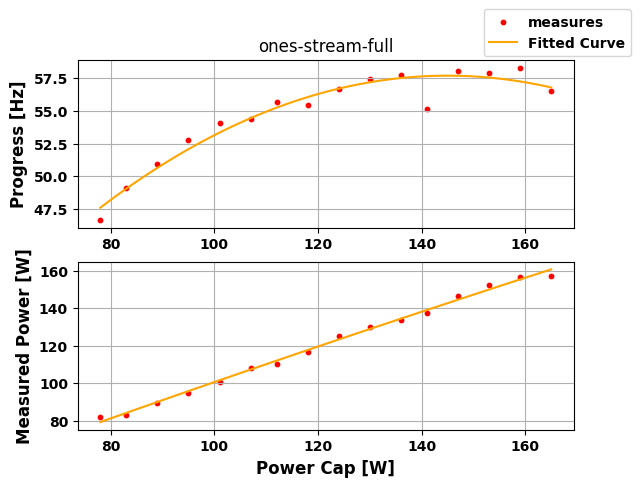

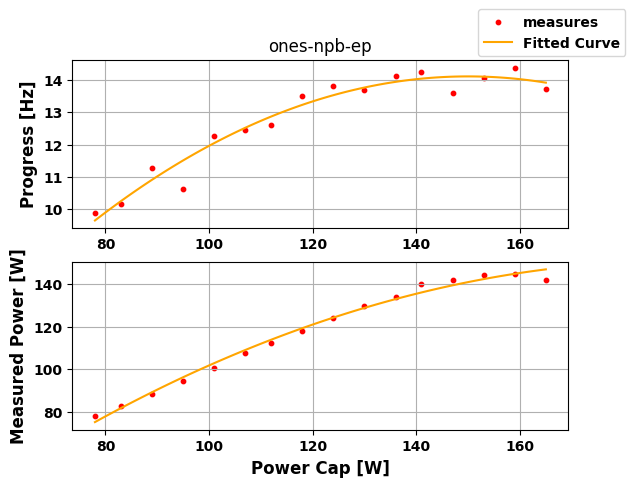

In [6]:
#### Uncomment this to see the time log plots of prgress and power
def compute_energy_consump(test_data_frame):
    total_energy = 0
    for i,t in enumerate(test_data_frame['average_power']['elapsed_time'].iloc[:-1]):
        total_energy += test_data_frame['average_power']['average_power'].iloc[i] * (test_data_frame['average_power']['elapsed_time'].iloc[i+1]-test_data_frame['average_power']['elapsed_time'].iloc[i])
    return total_energy


experiments = {'identification':'k'}
for dirs in experiments.keys():
    DATA_DIR = get_data_dir(dirs)
    root,folders,files = next(os.walk(DATA_DIR))
    test_results = {}
    for APP in folders:
        x_values = []
        perf_values = []
        power_values = []
        fig_perf,axs_perf = plt.subplots(2,1)
        axs_perf[0].set_title(APP)
        APP_DIR = os.path.join(DATA_DIR, APP)
        test_results[APP] = {}
        # print(next(os.walk(APP_DIR)))
        for tar_file in next(os.walk(APP_DIR))[2]:
            test_results[APP][tar_file] = {}
            if tar_file.endswith('.tar'):
                tar_path = os.path.join(APP_DIR,tar_file)
                extract_dir = os.path.join(APP_DIR,tar_file[:-4])  
                # print("------",tar_path)
                if not os.path.exists(extract_dir):
                    os.makedirs(extract_dir)
                
                with tarfile.open(tar_path, 'r') as tar:
                    tar.extractall(path=extract_dir)
            
            pubProgress = pd.read_csv(f'{extract_dir}/progress.csv')
            pubEnergy = pd.read_csv(f'{extract_dir}/energy.csv')
            pubPAPI = pd.read_csv(f'{extract_dir}/papi.csv')
            pubPCAP = pd.read_csv(f'{extract_dir}/PCAP_file.csv')
            pubPower = pd.read_csv(f'{extract_dir}/measured_power.csv')
            test_results[APP][tar_file]['energy'] = pubEnergy
            test_results[APP][tar_file]['power'] = compute_power(pubEnergy)
            test_results[APP][tar_file]['progress'] = measure_progress(pubProgress,test_results[APP][tar_file]['power'])
            test_results[APP][tar_file]['papi'] = collect_papi(pubPAPI)
            test_results[APP][tar_file]['PCAP'] = generate_PCAP(pubPCAP)
            test_results[APP][tar_file]['derived_papi'] = derived_papi(test_results[APP][tar_file]['papi'])   
            test_results[APP][tar_file]['sensed_power'] = collect_power(pubPower)
            stop = -1
            lw = 10
            # print(test_results[APP][tar_file])
            computed_energy = compute_energy_consump(test_results[APP][tar_file]['power'])
            # print("Total Energy consumed: ", computed_energy)
            # print("Total Execution Time: ", test_results[APP][tar_file]['energy'].time.iloc[-1]-test_results[APP][tar_file]['energy'].time.iloc[0])
            axs_perf[0].scatter(test_results[APP][tar_file]['PCAP']['value'].mean(),test_results[APP][tar_file]['progress']['progress_frequency_median']['median'].mean(),s=lw,label=f'measures',color='r')
            # axs_phase[1].scatter(test_results[APP][tar_file]['power']['average_power']['elapsed_time'].iloc[:stop],test_results[APP][tar_file]['power']['average_power']['average_power'].iloc[:stop],s=lw,label=f'{label_val}')
            axs_perf[1].scatter(test_results[APP][tar_file]['PCAP']['value'].mean(),test_results[APP][tar_file]['sensed_power']['average_power']['average_power'].mean(),s=lw,label=f'measures',color='r')
            # axs_phase[2].scatter(test_results[APP][tar_file]['PCAP']['elapsed_time'].values[:stop],test_results[APP][tar_file]['PCAP']['value'].values[:stop],s=lw,label=f'{label_val}')
            x_values.append(test_results[APP][tar_file]['PCAP']['value'].mean())
            perf_values.append(test_results[APP][tar_file]['progress']['progress_frequency_median']['median'].mean())
            power_values.append(test_results[APP][tar_file]['sensed_power']['average_power']['average_power'].mean())
            # if test_results[APP][tar_file]['sensed_power']['average_power']['average_power'].mean() < -1000:
                # print(APP,tar_file)
            axs_perf[1].set_xlabel("Power Cap [W]")
            axs_perf[0].set_ylabel("Progress [Hz]")
            axs_perf[0].grid(True)
            axs_perf[1].set_ylabel("Measured Power [W]")
            axs_perf[1].grid(True)
            # axs_phase[2].set_ylabel("PCAP [W]")
            # axs_phase[2].grid(True)

        
        
        degree = 2  # You can change this to fit a different degree polynomial
        coefficients_perf = np.polyfit(x_values, perf_values, degree)
        coefficients_pow = np.polyfit(x_values,power_values,degree)
        polynomial_perf = np.poly1d(coefficients_perf)
        polynomial_pow = np.poly1d(coefficients_pow)
        x_fit = np.linspace(min(x_values), max(x_values), 100)
        y_fit_perf = polynomial_perf(x_fit)
        y_fit_pow = polynomial_pow(x_fit)
        axs_perf[0].plot(x_fit, y_fit_perf, label=f'Fitted Curve', color='orange')
        axs_perf[1].plot(x_fit,y_fit_pow,label=f'Fitted Curve', color='orange')
        handles, labels = axs_perf[0].get_legend_handles_labels()
        unique_labels = dict(zip(labels, handles))  # Create a dictionary to keep unique labels
        fig_perf.legend(unique_labels.values(), unique_labels.keys(), loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=fig_perf.transFigure)
        fig_perf.savefig(f'static_characteristics_{APP}.pdf', format='pdf', bbox_inches='tight') 


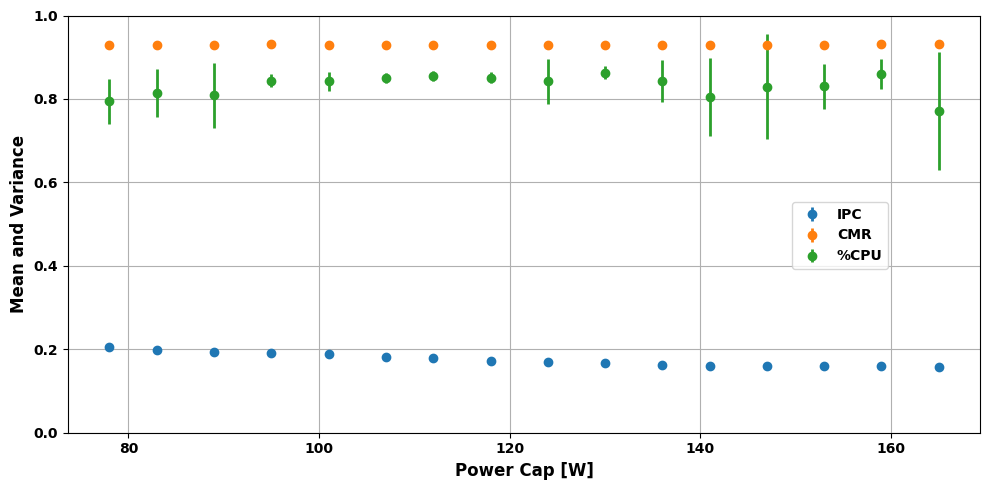

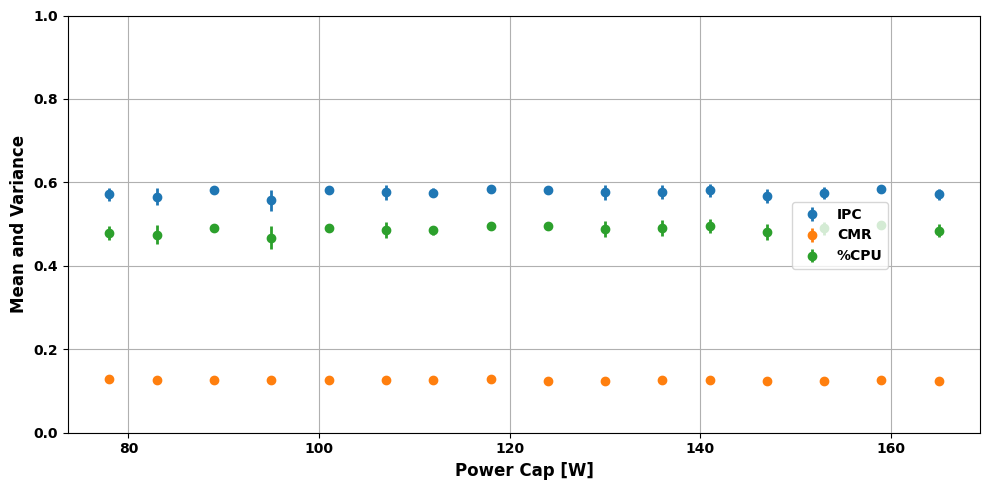

In [8]:
high_contrast_colors = plt.cm.tab10.colors[:4]

for APP in test_results.keys():
    x_values = []
    perf_values = []
    power_values = []
    fig_PAPI,axs_PAPI = plt.subplots(1,1, figsize=(10, 5))
    # axs_PAPI.set_title(APP)
    for tar_file in test_results[APP].keys():
        i = 0
        for POI_key in test_results[APP][tar_file]['derived_papi'].keys():
            if 'CPI' not in POI_key:
                POI = test_results[APP][tar_file]['derived_papi'][POI_key]
                mean = np.mean(POI.value)
                std = np.std(POI.value)
                label1= POI_key
                scatter_val = axs_PAPI.errorbar(test_results[APP][tar_file]['PCAP']['value'].mean(),
                mean,std,
                label=label1, elinewidth=2,fmt='o', color = high_contrast_colors[i])  # Increased error bar size
                i+=1
    handles, labels = axs_PAPI.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))  # Create a dictionary to keep unique labels    
    fig_PAPI.legend(unique_labels.values(), unique_labels.keys(), loc='upper right', bbox_to_anchor=(0.9, 0.6), bbox_transform=fig_PAPI.transFigure)
    axs_PAPI.grid(True)
    axs_PAPI.set_xlabel("Power Cap [W]")
    axs_PAPI.set_ylabel("Mean and Variance")
    axs_PAPI.set_ylim(0, 1)
    fig_PAPI.savefig(f'PAPI_stats_{APP}.pdf', format='pdf', bbox_inches='tight') 
    plt.tight_layout()